## Variational Autoencoders

This notebook implements a simple Variatonal Autoencoder (VAE) using the MNIST dataset.  A VAE is a neural network (in our case a convolutional neural network) with two parts; an encoder and a decoder.  The final result will be a generative model that lets us smoothly interpolate between two distinct images.  The orginal paper on VAEs can be found [here](https://arxiv.org/abs/1312.6114).

In [28]:
# import libraries
import IPython
import numpy as np
import torch
import random
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Module
from torchvision import datasets, transforms
from torch.autograd import Variable
import cv2
from skimage.metrics import peak_signal_noise_ratio
import os
import torchvision
import PIL
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms.functional as TF
from torchvision.datasets import MNIST

## Model

The purpose of an autoencoder (the non variational type) is to take some input $x$ and reduce its dimensions such that it can then be reconstructed with minimal corruption.  It is made up of two parts, an encoder $e$ and a decoder $d$. An input $x$ is passed through the encoder.  This generates a vector which we call a point in the latent space.  This vector is then passed though the decoder to get our output.  Mathmatically this can be described as

$$ (e^*, d^*) = \underset{(e,d)}{\text{arg min }} \epsilon(x,d(e(x)))$$

where $\epsilon$ is our reconstruction error.  Autoencoders can effectively perform dimensionality reduction, but the latent space is unstructured. Variational Autoencoders (VAEs) structure this latent space using regularization, thereby enforcing two nice properties; continuity (two close points in the latent space should look similar when decoded) and completeness (a sampled point should produce a meaningful output when decoded).  This regularization is acheived via the loss function described in the next section.  

Also note that VAEs encode an input as a distrubution, not a point.  The encoder still produces a vector, but half this vector describes the distributions mean $\mu$ and half describes the covariance $\sigma$.  This distribution is then sampled and the result is passed to the decoder.  So how can we backpropagate through a random sample?  This is done using the reparametrization trick, which means that instead of sampling using $z\sim\mathcal{N}(\mu,\sigma)$ we sample with

$$ z = \mu + \sigma \xi $$
$$ \xi \sim \mathcal{N}(0,I)$$

thus allowing us to backpropagate through, and learn, $\mu$ and $\sigma$.

In [46]:
class VAE(Module):

    def __init__(self, bottleneck_size, channel_size=1):
        super().__init__()
        self.bottleneck_size = bottleneck_size
        self.channel_size    = channel_size

        # Encoder Convolutional layers
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(channel_size, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 256, 3),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 1024, 3),
            nn.ReLU(True)
        )
        
        # Max pooling layer
        self.encoder_pooler = nn.Sequential(
            nn.MaxPool2d(2, stride=2, return_indices=True)
        )

        # Encoders first linear layer
        self.encoder_linear_1 = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(1024 * 10 * 10, bottleneck_size * 2),
            nn.ReLU(True)
        )

        # Bottle neck, ends up outputing the mean of the latent spaces distribution
        self.encoder_linear_21 = nn.Sequential(
            nn.Linear(bottleneck_size * 2, bottleneck_size),
        )

        # Bottle neck, ends up outputing the standard deviation of the latent spaces distribution
        self.encoder_linear_22 = nn.Sequential(
            nn.Linear(bottleneck_size * 2, bottleneck_size),
        )

        # Decoders linear layers 
        self.decoder_linear = nn.Sequential(
            nn.Linear(bottleneck_size, bottleneck_size * 2),
            nn.ReLU(True),
            nn.Linear(bottleneck_size * 2, 1024 * 10 * 10),
            nn.ReLU(True),
            nn.Unflatten(dim=1, unflattened_size=(1024, 10, 10))
        )

        # Reverses max pooling
        self.decoder_unpooler = nn.Sequential(
            nn.ConvTranspose2d(1024, 1024, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True)
        )

        # Decoders convolutional layers
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(1024, 256, 3),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, channel_size, 3),
            nn.Sigmoid()
        )

    
    def encoder(self,image):
        
        conv = self.encoder_conv(image)
        conv, _ = self.encoder_pooler(conv)
        code = self.encoder_linear_1(conv)

        mu = self.encoder_linear_21(code)
        std = torch.exp(self.encoder_linear_22(code))

        return mu, std
    
    def reparametrization_trick(self,mu,std):
        
        sample = torch.randn_like(std)
        z = mu + (std * sample)
 
        return z
    
    def decoder(self,code):

        linear = self.decoder_linear(code)
        unflat = self.decoder_unpooler(linear)
        decoded_image = self.decoder_conv(unflat)

        return decoded_image
    
    def forward(self, image):
    
        mu, std = self.encoder(image)
        z = self.reparametrization_trick(mu, std)
        decoded_image = self.decoder(z)
        
        return decoded_image, mu, std

bottleneck_size = 256
model = VAE(bottleneck_size)
print("Num params: ", sum(p.numel() for p in model.parameters()))

Num params:  119828225


## Loss Function

The loss function for VAEs has two components, reconsturction loss and regularization loss (KL divergence).


**Reconsturction loss** - This is the same loss an ordinary autoencoder would use.  The aim of this loss is to ensure the input $x$ and output $y$ are as close as possible to eachother.  For this component we simply need to take the sum of square differences between $x$ and $y$
$$ L_{recon} = \sum_{n=1}^N{(x_n-y_n)^2} $$

**Regularization loss** - KL divergence $D_{KL}$ is a metric which compares two distributions, the largers the KL divergence, the larger the difference between the two distribution.  The two distributions in question here are $p(z|x)$, the probability distribution that projects our data $x$ into latent space $z$, and a simplified estimate of that distribution $q(z|x)$


$$
\begin{align}
L_{reg} && = && D_{KL}( ~ q(z|x) ~ || ~ p(z|x) ~ ) ~~~~~~~~\\
 && = && \sum_{m=1}^M{\sigma_m^2+\mu_m^2-\text{log}(\sigma_m) - 1}\\
\end{align}
$$

where $\mu$ is the latent spaces current mean and $\sigma$ is the current covariance.  How we went from the first to the second line here isn't obvious, so for the full derivation see [this stack exchange answer](https://stats.stackexchange.com/questions/318748/deriving-the-kl-divergence-loss-for-vaes/370048#370048).  

**Final Loss** - Our final loss function is therefore

$$ L_{final} = L_{recon} + L_{reg} $$


In [175]:
def reconstruction_loss(input,target):
    # Sum of square differences loss function
    recon_loss = ((target - input)**2).sum()
    return recon_loss

def kl_divergence_loss(mu,std):
    # KL divergence (see explaination above)
    kl_loss = (std**2 + mu**2 - torch.log(std) - 1).sum()
    # multiply by scaler to increase importance
    kl_loss *= 0.5 # Play around with this value if you're getting junk outputs
    
    return kl_loss

## Data

Download and plot some examples from the training data.

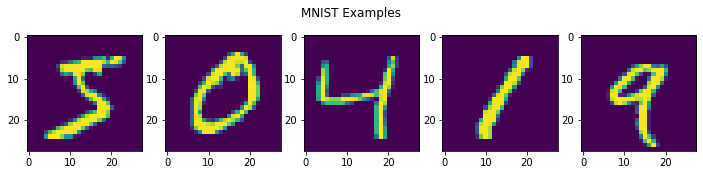

In [176]:
# Are we using the CPU or the GPU?
device = "cuda" if torch.cuda.is_available() else "cpu"

# Transforms to be applied to all images in the dataset
tf = transforms.Compose(
    [transforms.ToTensor()]
)

# Download/setup the MNIST dataset
dataset = MNIST(
    "./data",
    train=True,
    download=True,
    transform=tf,
)

# Plot examples
fig, ax= plt.subplots(1, 5, figsize=(12, 2.5))
fig.suptitle('MNIST Examples')
ax[0].imshow(dataset[0][0][0,:,:].numpy())
ax[1].imshow(dataset[1][0][0,:,:].numpy())
ax[2].imshow(dataset[2][0][0,:,:].numpy())
ax[3].imshow(dataset[3][0][0,:,:].numpy())
ax[4].imshow(dataset[4][0][0,:,:].numpy())


## Training

The model is trained like so:
1. The input is encoded as a distribution over the latent space
2. We take a point in the latent space by sampling from this distribution
3. Pass the sampled point through the decoder to get an output
4. Backpropagate through the network using the reconstruction loss and KL divergence loss

In [177]:
# Create out neural network
model = VAE(bottleneck_size)
model.to(device)

# Define hyperparameters
num_epochs = 5
batch_size = 256

# Define optimiser and dataset objects
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-5)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Loss history arrays
loss_history = []
re_loss_history = []
kl_loss_history = []

# Training loop
for epoch in range(num_epochs):
    # Reset total loss trackers
    total_loss = 0
    total_kl_loss = 0
    total_re_loss = 0

    # Iterate over all MNIST dataset items
    for data in dataloader:
        # Load a batch of MNIST images in to memory
        img = Variable(data[0])
        img = img.to(device)

        # Forward Pass
        output, mu, std = model(img)

        # Calculate loss
        re_loss = reconstruction_loss(output, img)
        kl_loss = kl_divergence_loss(mu, std)
        loss = re_loss + kl_loss
        total_loss += loss.item()
        total_re_loss += re_loss.item()
        total_kl_loss += kl_loss.item()

        # Backwards Pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    # Save and print loss
    loss_history.append(total_loss / len(dataset))
    re_loss_history.append(re_loss / len(dataset))
    kl_loss_history.append(kl_loss / len(dataset))
    print('Epoch [{}/{}], Loss:{:.4f}'.format(epoch+1, num_epochs, total_loss / len(dataset)), ", Reconstruction Loss:", (total_re_loss / len(dataset)), ", KL Divergence:", (total_kl_loss / len(dataset)))

torch.save(model, 'checkpoint_vae.pth')

Epoch [1/5], Loss:42349527445676.6562 , Reconstruction Loss: 51.563853873697916 , KL Divergence: 42349527445625.586
Epoch [2/5], Loss:18.2388 , Reconstruction Loss: 31.400354516601563 , KL Divergence: -13.16159814860026
Epoch [3/5], Loss:13.6384 , Reconstruction Loss: 25.266604134114584 , KL Divergence: -11.628205969238282
Epoch [4/5], Loss:9.3367 , Reconstruction Loss: 20.801589723714194 , KL Divergence: -11.464872692871094
Epoch [5/5], Loss:6.6138 , Reconstruction Loss: 18.056749934895834 , KL Divergence: -11.44295527750651


## Sampling

Here we sample two points in the latent space and interpolate between them.  The result should be that we see one image smoothly morphing into the other.

In [222]:
# Sample two random vectors representing two random points in the latent space 
rand_vector_1 = torch.randn(1,bottleneck_size)
rand_vector_2 = torch.randn(1,bottleneck_size)
rand_vector_1 = rand_vector_1.to(device)
rand_vector_2 = rand_vector_2.to(device)

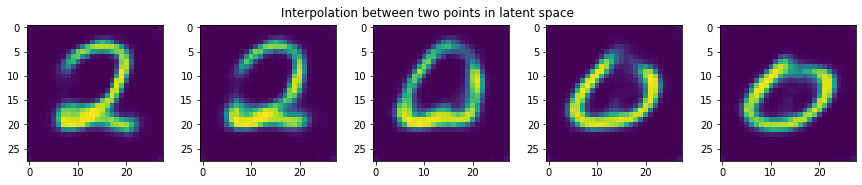

In [223]:
# Define the plots
number_of_samples = 5
fig, axes = plt.subplots(1, number_of_samples, figsize=(15,2.5))
fig.suptitle('Interpolation between two points in latent space')

# Decode 5 points in latent space and plot the images
for i in range(number_of_samples):

    # Interpolate between the two points
    rand_vector = rand_vector_1 * (1 - (0.25 * i)) + rand_vector_2 * (0.25 * i)
    rand_vector.to(device)
    # Generate the image
    random_image = model.decoder(rand_vector)
    # Display the image
    img = random_image.cpu().detach().numpy()[0].transpose(1,2,0)
    axes[i].imshow(img[:,:,0])
